# Configurações iniciais
Importação das bibliotecas que serão usadas e configuração das visualizações.

In [ ]:
!pip install missingno 

# Importação dos pacotes necessários
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import random

# Configuração das visualizações
sns.set_style('darkgrid')
sns.set_palette('Accent')

# Obtenção dos Dados
Importação dos datasets a serem utilizados.

In [ ]:
# Obtenção dos dados do dataset 1
data_path = 'http://data.insideairbnb.com/france/ile-de-france/paris/2021-07-06/data/listings.csv.gz'

df = pd.read_csv(data_path)
df.head(10)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2577,https://www.airbnb.com/rooms/2577,20210706215602,2021-07-08,Loft for 4 by Canal Saint Martin,"100 m2 loft (1100 sq feet) with high ceiling, ...",NaN,https://a0.muscache.com/pictures/09da057c-0120...,2827,https://www.airbnb.com/users/show/2827,Karine,2008-09-09,"Montreuil, Île-de-France, France","Arrivée à Casablanca il y a 4 ans, je suis amo...",NaN,NaN,0%,f,https://a0.muscache.com/im/pictures/user/17fe6...,https://a0.muscache.com/im/pictures/user/17fe6...,République,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Entrepôt,NaN,48.869570,2.361270,Entire loft,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Long term stays allowed"", ""Dryer"", ""Kitchen""...",$125.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,30,59,89,364,2021-07-08,1,0,0,2019-01-02,2019-01-02,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,t,1,1,0,0,0.03
1,5396,https://www.airbnb.com/rooms/5396,20210706215602,2021-07-08,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","You are within walking distance to the Louvre,...",https://a0.muscache.com/pictures/52413/f9bf76f...,7903,https://www.airbnb.com/users/show/7903,Borzou,2009-02-14,"Istanbul, İstanbul, Turkey",We are both journalists based in the Middle Ea...,within an hour,100%,89%,f,https://a0.muscache.com/im/users/7903/profile_...,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,1.0,1.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,t,"Paris, Ile-de-France, France",Hôtel-de-Ville,NaN,48.852470,2.358350,Entire apartment,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Drying rack for clothing"", ""Long term stays ...",$64.00,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,12,23,23,2021-07-08,250,27,4,2013-09-22,2020-08-08,4.51,4.54,4.46,4.77,4.82,4.96,4.53,7510402838018,f,1,1,0,0,2.63
2,7397,https://www.airbnb.com/rooms/7397,20210706215602,2021-07-08,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !<br /...",NaN,https://a0.muscache.com/pictures/67928287/330b...,2626,https://www.airbnb.com/users/show/2626,Franck,2008-08-30,"Paris, Île-de-France, France","I am a writer,51, author of novels, books of l...",within an hour,98%,78%,t,https://a0.muscache.com/im/pictures/user/58f00...,https://a0.muscache.com/im/pictures/user/58f00...,Le Marais,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Hôtel-de-Ville,NaN,48.859090,2.353150,Entire apartment,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Paid parking off premises"", ""Long term stays...",$93.00,9,130,3.0,9.0,130.0,130.0,8.9,130.0,NaN,t,3,9,11,209,2021-07-08,273,5,1,2011-08-11,2020-02-26,4.70,4.78,4.44,4.90,4.89,4.92,4.70,7510400829623,f,2,2,0,0,2.26
3,7964,ht

In [ ]:
# Tamanho do dataset 1
df.shape

(51040, 74)

In [ ]:
# Obtenção dos dados do dataset 2
data_path2 = 'https://raw.githubusercontent.com/alicesauteleitao/parisairbnb/main/Top%20Paris%20Sights.csv'

df_geo = pd.read_csv(data_path2)
df_geo.head(10)



,attractions,lat,long
0,Tour Eiffel,48.858303,2.294506
1,Louvre,48.861013,2.335874
2,Notre Dame,48.852930,2.350050
3,Arc du Triomphe,48.873780,2.295038
4,Sacre Coeur,48.885619,2.343230
5,Panthéon,48.846177,2.346073
6,Place des Vosges,48.855628,2.365549


In [ ]:
# Tamanho do dataset 2
df_geo.shape

(7, 3)

# Preparação dos dados
Em um primeiro momento, limpou-se a base de dados, excluindo campos com todos os dados faltantes e exlcuindo campos que não serão úteis para essa análise.

In [ ]:
# Cálculo do percentual de dados faltantes no Dataset

(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

bathrooms                       1.000000
neighbourhood_group_cleansed    1.000000
calendar_updated                1.000000
host_response_time              0.539734
host_response_rate              0.539734
                                  ...   
calendar_last_scraped           0.000000
neighbourhood_cleansed          0.000000
number_of_reviews               0.000000
availability_30                 0.000000
id                              0.000000
Length: 74, dtype: float64

In [ ]:
# Exclusão dos campos com todos os dados faltantes
df = df.drop(['bathrooms', 'neighbourhood_group_cleansed', 'calendar_updated'], axis=1)

(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

host_response_rate        0.539734
host_response_time        0.539734
host_acceptance_rate      0.514126
host_about                0.479193
license                   0.478468
                            ...   
latitude                  0.000000
neighbourhood_cleansed    0.000000
calendar_last_scraped     0.000000
availability_60           0.000000
id                        0.000000
Length: 71, dtype: float64

In [ ]:
# Exclusão de campos irrelevantes para a análise
df = df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'amenities', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',  'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1)
df.shape

(51040, 32)

In [ ]:
# Exclusão de campos redundantes conceitualmente
df = df.drop(['neighbourhood', 'property_type', 'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month'], axis=1)
df.shape

(51040, 17)

Index(['host_is_superhost', 'host_has_profile_pic', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'instant_bookable'],
      dtype='object')

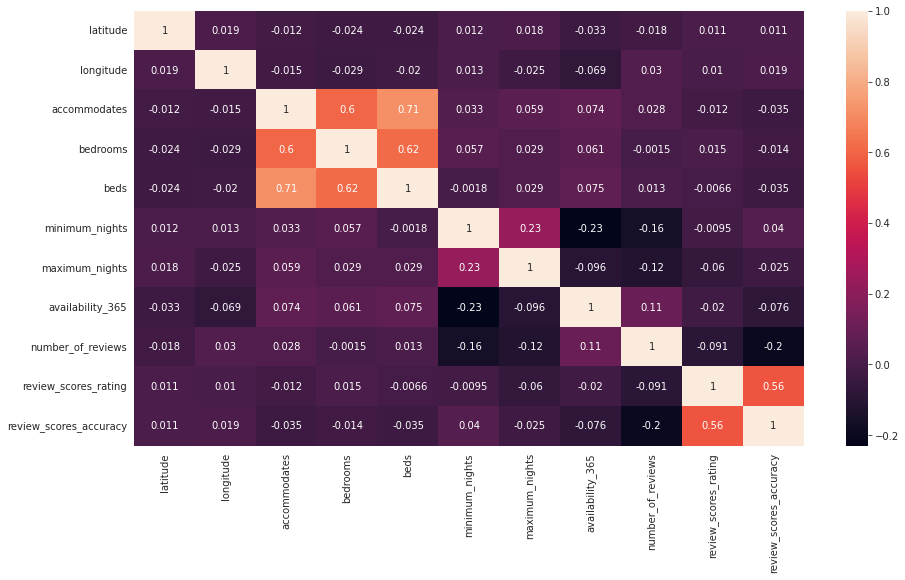

In [ ]:
# Correlação entre os dados para identificar outras possíveis variáveis redundantes
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df.columns

In [ ]:
# Exclusão de campos redundantes de acordo com a análise de correlação
df = df.drop(['bedrooms', 'beds', 'review_scores_accuracy'], axis=1)
df.shape

(51040, 14)

# Cruzamento de datasets
Buscando obter novos dados sobre a distância de cada acomodação a pontos turísticos, foi realizado o cruzamento dos dois datasets e o cálculo, através da latitude e da longitude das acomodações e das atrações, da distância entre cada um.

In [ ]:
# Função que calcula a distância de um ponto a outro
def distance(s_lat, s_lng, e_lat, e_lng):
    
    # raio da terra em km
    R = 6373.0
    
    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d))

In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e a Torre Eiffel

lat_TourEiffel = df_geo.iloc[0]['lat']
lng_TourEiffel = df_geo.iloc[0]['long']

df['distance_to_TourEiffel'] = (distance(df['latitude'], df['longitude'], lat_TourEiffel, lng_TourEiffel))
df.head()


,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582


In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e o Louvre

lat_Louvre = df_geo.iloc[1]['lat']
lng_Louvre = df_geo.iloc[1]['long']

df['distance_to_Louvre'] = (distance(df['latitude'], df['longitude'], lat_Louvre, lng_Louvre))
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472,2.087812
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253,1.899610
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469,1.282193
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961,1.540517
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582,0.939451


In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e a Notre Dame

lat_NotreDame = df_geo.iloc[2]['lat']
lng_NotreDame = df_geo.iloc[2]['long']

df['distance_to_NotreDame'] = (distance(df['latitude'], df['longitude'], lat_NotreDame, lng_NotreDame))
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472,2.087812,2.024797
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253,1.899610,0.609619
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469,1.282193,0.721759
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961,1.540517,2.427091
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582,0.939451,0.799848


In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e o Arc du Triomphe

lat_Arc = df_geo.iloc[3]['lat']
lng_Arc = df_geo.iloc[3]['long']

df['distance_to_Arc'] = (distance(df['latitude'], df['longitude'], lat_Arc, lng_Arc))
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472,2.087812,2.024797,4.868185
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253,1.899610,0.609619,5.203934
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469,1.282193,0.721759,4.555133
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961,1.540517,2.427091,3.468829
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582,0.939451,0.799848,4.207720


In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e a Sacre Coeur

lat_SacreCoeur = df_geo.iloc[4]['lat']
lng_SacreCoeur = df_geo.iloc[4]['long']

df['distance_to_SacreCoeur'] = (distance(df['latitude'], df['longitude'], lat_SacreCoeur, lng_SacreCoeur))
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472,2.087812,2.024797,4.868185,2.219958
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253,1.899610,0.609619,5.203934,3.849537
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469,1.282193,0.721759,4.555133,3.038754
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961,1.540517,2.427091,3.468829,1.274748
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582,0.939451,0.799848,4.207720,2.870241


In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e o Pantheon
lat_Pantheon = df_geo.iloc[5]['lat']
lng_Pantheon = df_geo.iloc[5]['long']

df['distance_to_Pantheon'] = (distance(df['latitude'], df['longitude'], lat_Pantheon, lng_Pantheon))
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472,2.087812,2.024797,4.868185,2.219958,2.829708
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253,1.899610,0.609619,5.203934,3.849537,1.139052
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469,1.282193,0.721759,4.555133,3.038754,1.526850
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961,1.540517,2.427091,3.468829,1.274748,3.124924
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582,0.939451,0.799848,4.207720,2.870241,1.555502


In [ ]:
# Criando um novo campo a partir da distância entre cada acomodação e a Place des Vosges
lat_Place = df_geo.iloc[6]['lat']
lng_Place = df_geo.iloc[6]['long']

df['distance_to_Place'] = (distance(df['latitude'], df['longitude'], lat_Place, lng_Place))
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon,distance_to_Place
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,$125.00,3,1125,364,1,5.00,t,5.043472,2.087812,2.024797,4.868185,2.219958,2.829708,1.582061
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,$64.00,1,1125,23,250,4.51,f,4.717253,1.899610,0.609619,5.203934,3.849537,1.139052,0.633231
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,$93.00,9,130,209,273,4.70,f,4.292469,1.282193,0.721759,4.555133,3.038754,1.526850,0.985714
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,$130.00,6,365,352,6,4.80,f,3.926961,1.540517,2.427091,3.468829,1.274748,3.124924,2.666514
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,$75.00,180,365,358,0,NaN,f,3.965582,0.939451,0.799848,4.207720,2.870241,1.555502,1.332685


# Tratamento dos dados
Agora, com um dataset unificado e campos considerados relevantes para essa análise, foi realizado o tratamento dos dados para que esses possam ser analisados.

In [ ]:
# Tamanho do dataset
df.shape

(51040, 21)

In [ ]:
# Variáveis e seus formatos
display(df.dtypes)

host_is_superhost          object
host_has_profile_pic       object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
room_type                  object
accommodates                int64
price                      object
minimum_nights              int64
maximum_nights              int64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
instant_bookable           object
distance_to_TourEiffel    float64
distance_to_Louvre        float64
distance_to_NotreDame     float64
distance_to_Arc           float64
distance_to_SacreCoeur    float64
distance_to_Pantheon      float64
distance_to_Place         float64
dtype: object

In [ ]:
# Transformando a variável price em uma variável numérica
df['price'] = df['price'].str.replace(r'\D+', '').astype('float')

In [ ]:
# Corrigindo o valor da variável price
df['price'] = df['price']/100
df.head()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon,distance_to_Place
0,f,t,Entrepôt,48.86957,2.36127,Entire home/apt,4,125.0,3,1125,364,1,5.00,t,5.043472,2.087812,2.024797,4.868185,2.219958,2.829708,1.582061
1,f,t,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,2,64.0,1,1125,23,250,4.51,f,4.717253,1.899610,0.609619,5.203934,3.849537,1.139052,0.633231
2,t,t,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,4,93.0,9,130,209,273,4.70,f,4.292469,1.282193,0.721759,4.555133,3.038754,1.526850,0.985714
3,f,t,Opéra,48.87417,2.34245,Entire home/apt,2,130.0,6,365,352,6,4.80,f,3.926961,1.540517,2.427091,3.468829,1.274748,3.124924,2.666514
4,f,t,Louvre,48.86006,2.34863,Entire home/apt,2,75.0,180,365,358,0,NaN,f,3.965582,0.939451,0.799848,4.207720,2.870241,1.555502,1.332685


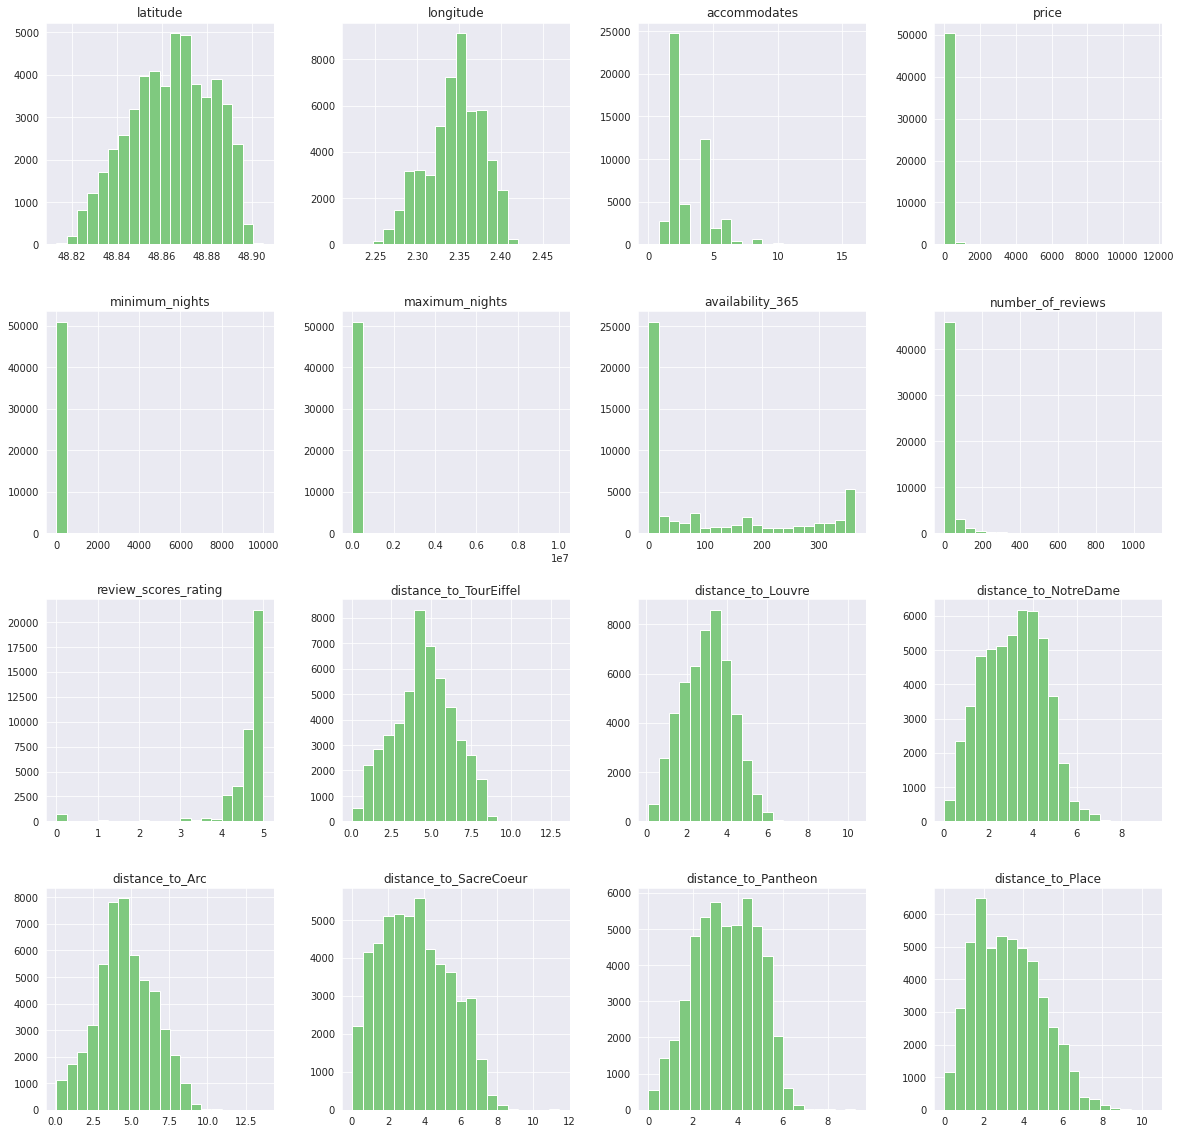

In [ ]:
# Histogramas das variáveis do dataset

df.hist(bins=20, figsize=(20,20));

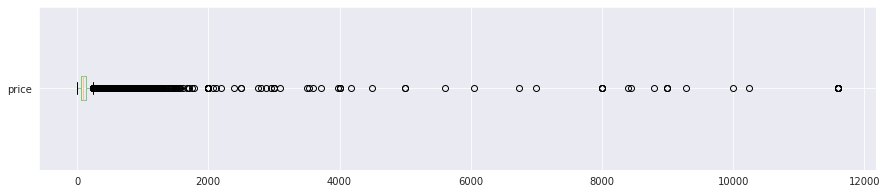

In [ ]:
# Construção do Boxplot para variável price.

df.price.plot(kind='box', vert=False, figsize=(15, 3))
plt.show()

In [ ]:
# Valores acima de 600 para price

print("{} entradas".format(len(df[df.price > 600])))
print("{:.4f}%".format((len(df[df.price > 600]) / df.shape[0])*100))

614 entradas
1.2030%


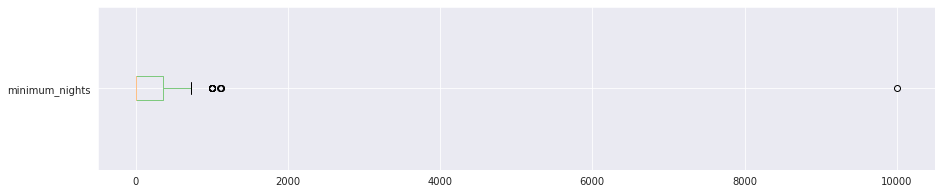

In [ ]:
# Construção do Boxplot para variável minimum_nights.

df.minimum_nights.plot(kind='box', vert=False, figsize=(15, 3))
plt.show()

In [ ]:
# Valores acima de 365 para minimum_nights

print("{} entradas".format(len(df[df.minimum_nights > 365])))
print("{:.4f}%".format((len(df[df.minimum_nights > 365]) / df.shape[0])*100))

21 entradas
0.0411%


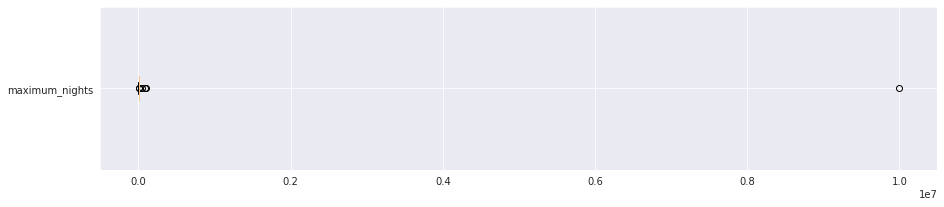

In [ ]:
# Construção do Boxplot para variável maximum_nights.

df.maximum_nights.plot(kind='box', vert=False, figsize=(15, 3))
plt.show()

In [ ]:
# Valores acima de 1125 para maximum_nights

print("{} entradas".format(len(df[df.maximum_nights > 1125])))
print("{:.4f}%".format((len(df[df.maximum_nights > 1125]) / df.shape[0])*100))

11 entradas
0.0216%


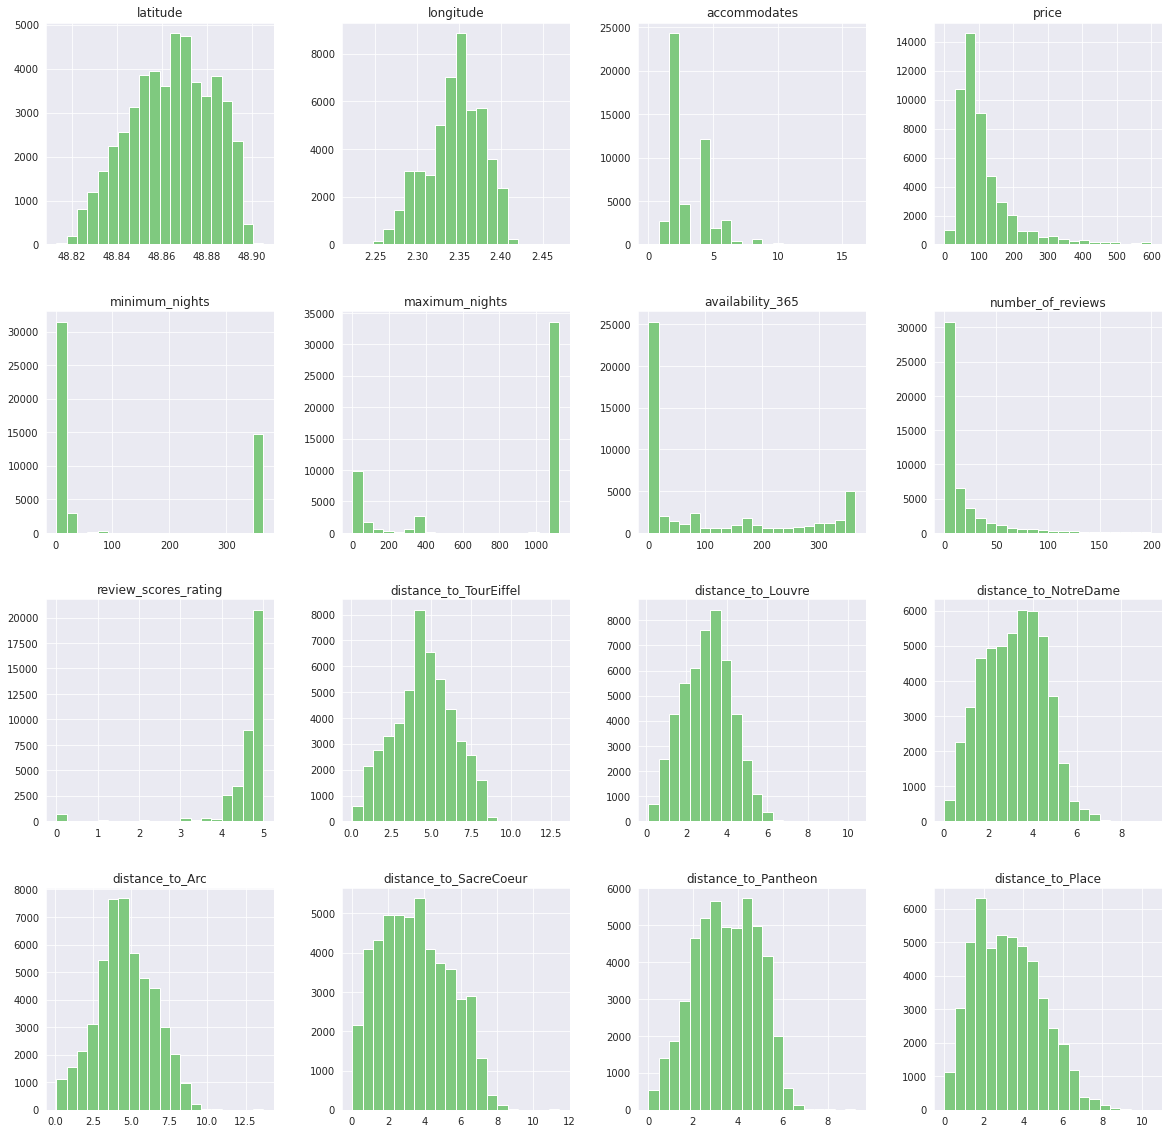

In [ ]:
# Excluindo outliers

df_clean = df.copy()
df_clean.drop(df_clean[df_clean.price > 600].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.minimum_nights > 365].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.maximum_nights > 1125].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.number_of_reviews > 200].index, axis=0, inplace=True)

df_clean.hist(bins=20, figsize=(20,20));

In [ ]:
df_clean.shape

(49786, 21)

In [ ]:
# Identificando elementos faltantes nos campos restantes

(df_clean.isnull().sum() / df.shape[0]).sort_values(ascending=False)

review_scores_rating      0.237716
host_is_superhost         0.001587
host_has_profile_pic      0.001587
maximum_nights            0.000000
neighbourhood_cleansed    0.000000
latitude                  0.000000
longitude                 0.000000
room_type                 0.000000
accommodates              0.000000
price                     0.000000
minimum_nights            0.000000
distance_to_Place         0.000000
distance_to_Pantheon      0.000000
number_of_reviews         0.000000
instant_bookable          0.000000
distance_to_TourEiffel    0.000000
distance_to_Louvre        0.000000
distance_to_NotreDame     0.000000
distance_to_Arc           0.000000
distance_to_SacreCoeur    0.000000
availability_365          0.000000
dtype: float64

In [ ]:
# Resumo estatístico dos dados
df_clean.describe()

,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon,distance_to_Place
count,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,37653.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000
mean,48.864000,2.345086,3.026493,109.869602,112.581408,798.476058,102.554353,17.037179,4.586515,4.551292,3.027555,3.138792,4.600355,3.500386,3.471743,3.223741
std,0.018317,0.033258,1.580996,84.014750,164.030520,480.911250,133.741178,29.689192,0.762049,1.860207,1.213481,1.367858,1.870998,1.902473,1.399285,1.670891
min,48.812870,2.222510,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.090822,0.114255,0.020849,0.083779,0.028759,0.014107,0.008084
25%,48.850660,2.324290,2.000000,60.000000,2.000000,240.000000,0.000000,1.000000,4.500000,3.303007,2.122184,2.056854,3.385337,1.955735,2.412906,1.849263
50%,48.865320,2.348100,2.000000,85.000000,4.000000,1125.000000,15.000000,5.000000,4.780000,4.541977,3.070787,3.193575,4.483478,3.391503,3.481577,3.087842
75%,48.878730,2.369817,4.000000,128.000000,365.000000,1125.000000,188.000000,19.000000,5.000000,5.841029,3.855830,4.170641,5.923556,4.978590,4.584547,4.397880
max,48.905140,2.469966,16.000000,600.000000,365.000000,1125.000000,365.000000,200.000000,5.000000,13.021100,10.352418,9.374742,13.659750,11.430978,9.239726,10.479511


In [ ]:
# Substituindo valores faltantes em review_scores_rating pela média

df_clean['review_scores_rating'].fillna(4.586515, inplace=True)

In [ ]:
# Identificando elementos faltantes nos campos restantes

(df_clean.isnull().sum() / df.shape[0]).sort_values(ascending=False)

host_is_superhost         0.001587
host_has_profile_pic      0.001587
maximum_nights            0.000000
neighbourhood_cleansed    0.000000
latitude                  0.000000
longitude                 0.000000
room_type                 0.000000
accommodates              0.000000
price                     0.000000
minimum_nights            0.000000
distance_to_Place         0.000000
distance_to_Pantheon      0.000000
number_of_reviews         0.000000
review_scores_rating      0.000000
instant_bookable          0.000000
distance_to_TourEiffel    0.000000
distance_to_Louvre        0.000000
distance_to_NotreDame     0.000000
distance_to_Arc           0.000000
distance_to_SacreCoeur    0.000000
availability_365          0.000000
dtype: float64

In [ ]:
# Excluindo dados faltantes
df_clean.dropna()

,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon,distance_to_Place
0,f,t,Entrepôt,48.869570,2.361270,Entire home/apt,4,125.0,3,1125,364,1,5.000000,t,5.043472,2.087812,2.024797,4.868185,2.219958,2.829708,1.582061
3,f,t,Opéra,48.874170,2.342450,Entire home/apt,2,130.0,6,365,352,6,4.800000,f,3.926961,1.540517,2.427091,3.468829,1.274748,3.124924,2.666514
4,f,t,Louvre,48.860060,2.348630,Entire home/apt,2,75.0,180,365,358,0,4.586515,f,3.965582,0.939451,0.799848,4.207720,2.870241,1.555502,1.332685
5,t,t,Popincourt,48.863730,2.370930,Entire home/apt,2,80.0,4,31,144,28,4.930000,f,5.624944,2.582955,1.943682,5.664077,3.167694,2.668582,0.983459
6,t,t,Buttes-Montmartre,48.887000,2.345310,Entire home/apt,2,80.0,30,300,279,48,4.840000,f,4.899314,2.971817,3.805435,3.960418,0.216193,4.541079,3.790667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,f,t,Temple,48.856903,2.367632,Entire home/apt,4,50.0,30,306,364,0,4.586515,f,5.353740,2.368568,1.360503,5.633685,3.659158,1.978159,0.208189
51036,f,t,Bourse,48.866792,2.352358,Entire home/apt,5,105.0,3,1125,76,0,4.586515,f,4.337282,1.366731,1.551082,4.265102,2.198005,2.338668,1.572831
51037,f,t,Luxembourg,48.843620,2.331130,Private room,2,68.0,4,12,12,0,4.586515,f,3.138905,1.965531,1.729217,4.269659,4.754702,1.130204,2.851411
51038,f,t,Buttes-Chaumont,48.885520,2.385980,Entire home/apt,2,70.0,4,1125,10,0,4.586515,f,7.345192,4.568141,4.477848,6.779316,3.126791,5.260863,3.645440


# Análise e exploração dos dados
Com a base limpa, foram construídas visualizações que nos permitem conhecer a base trabalhada de forma mais aprofundada e perceber como os dados estão dispostos geograficamente. Foi possível realizar diferentes análises dos dados nesse momento.

In [ ]:
df_clean.describe()

,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon,distance_to_Place
count,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000,49786.000000
mean,48.864000,2.345086,3.026493,109.869602,112.581408,798.476058,102.554353,17.037179,4.586515,4.551292,3.027555,3.138792,4.600355,3.500386,3.471743,3.223741
std,0.018317,0.033258,1.580996,84.014750,164.030520,480.911250,133.741178,29.689192,0.662717,1.860207,1.213481,1.367858,1.870998,1.902473,1.399285,1.670891
min,48.812870,2.222510,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.090822,0.114255,0.020849,0.083779,0.028759,0.014107,0.008084
25%,48.850660,2.324290,2.000000,60.000000,2.000000,240.000000,0.000000,1.000000,4.586515,3.303007,2.122184,2.056854,3.385337,1.955735,2.412906,1.849263
50%,48.865320,2.348100,2.000000,85.000000,4.000000,1125.000000,15.000000,5.000000,4.640000,4.541977,3.070787,3.193575,4.483478,3.391503,3.481577,3.087842
75%,48.878730,2.369817,4.000000,128.000000,365.000000,1125.000000,188.000000,19.000000,4.900000,5.841029,3.855830,4.170641,5.923556,4.978590,4.584547,4.397880
max,48.905140,2.469966,16.000000,600.000000,365.000000,1125.000000,365.000000,200.000000,5.000000,13.021100,10.352418,9.374742,13.659750,11.430978,9.239726,10.479511


### Localização

In [ ]:
df_clean.neighbourhood_cleansed.unique()

array(['Entrepôt', 'Opéra', 'Louvre', 'Popincourt', 'Buttes-Montmartre',
       'Batignolles-Monceau', 'Gobelins', 'Luxembourg', 'Buttes-Chaumont',
       'Reuilly', 'Bourse', 'Élysée', 'Vaugirard', 'Ménilmontant',
       'Observatoire', 'Panthéon', 'Palais-Bourbon', 'Hôtel-de-Ville',
       'Passy', 'Temple'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


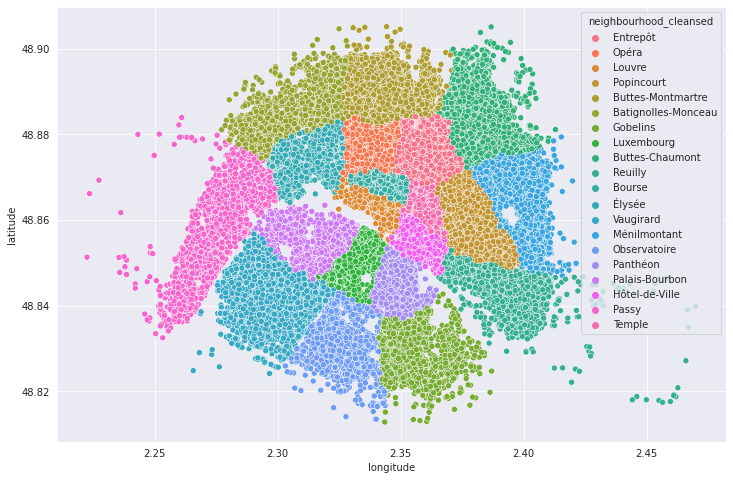

In [ ]:
# Visualização por bairro

plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_clean.longitude,df_clean.latitude,hue=df_clean.neighbourhood_cleansed)
plt.ioff()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


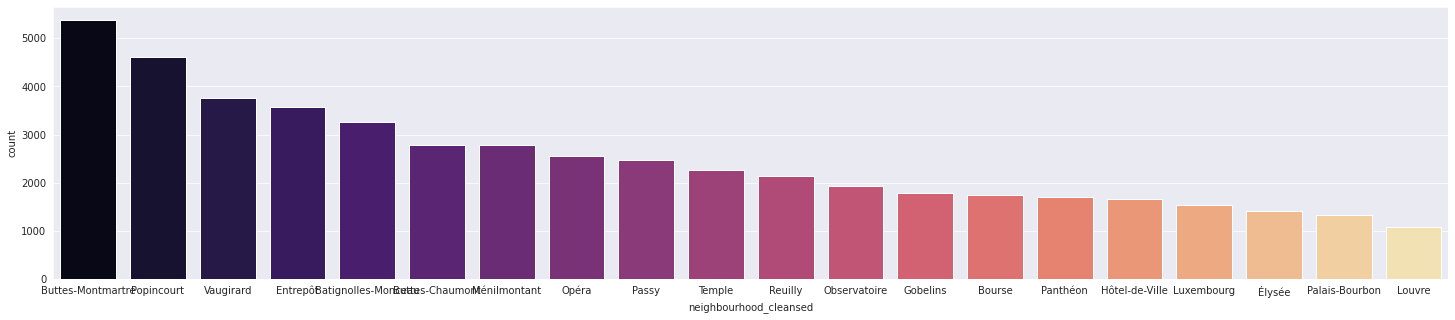

In [ ]:
# Quantidade de imóveis por bairro

sns.countplot(df_clean['neighbourhood_cleansed'], order=df_clean['neighbourhood_cleansed'].value_counts().index, palette='magma')
fig = plt.gcf()
fig.set_size_inches(25,5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


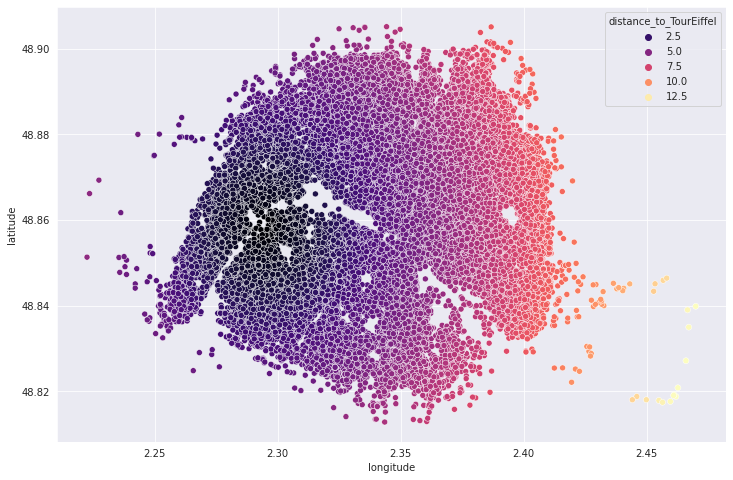

In [ ]:
# Visualização por distância da Torre Eiffel

plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_clean.longitude,df_clean.latitude,hue=df_clean.distance_to_TourEiffel,palette='magma')
plt.ioff()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


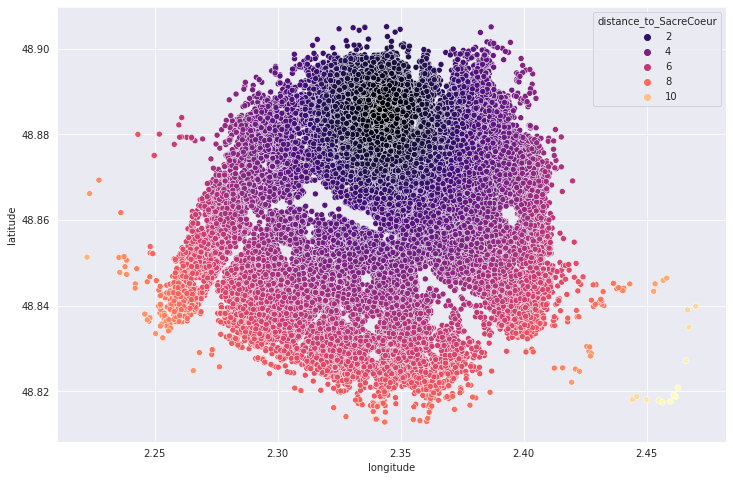

In [ ]:
# Visualização por distância da Sacre Coeur

plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_clean.longitude,df_clean.latitude,hue=df_clean.distance_to_SacreCoeur,palette='magma')
plt.ioff()

### Preço

In [ ]:
# Média de preço por bairro

df_clean.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)[:30] 

neighbourhood_cleansed
Élysée                 174.775265
Louvre                 164.862799
Luxembourg             155.238932
Palais-Bourbon         154.168539
Hôtel-de-Ville         149.095353
Bourse                 145.643389
Temple                 139.738095
Passy                  137.314379
Panthéon               126.616883
Opéra                  124.789062
Vaugirard              104.700982
Batignolles-Monceau    101.612032
Entrepôt               100.157319
Observatoire            95.261745
Popincourt              93.491114
Reuilly                 86.300281
Buttes-Montmartre       85.048894
Gobelins                84.829336
Buttes-Chaumont         74.749194
Ménilmontant            74.610572
Name: price, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


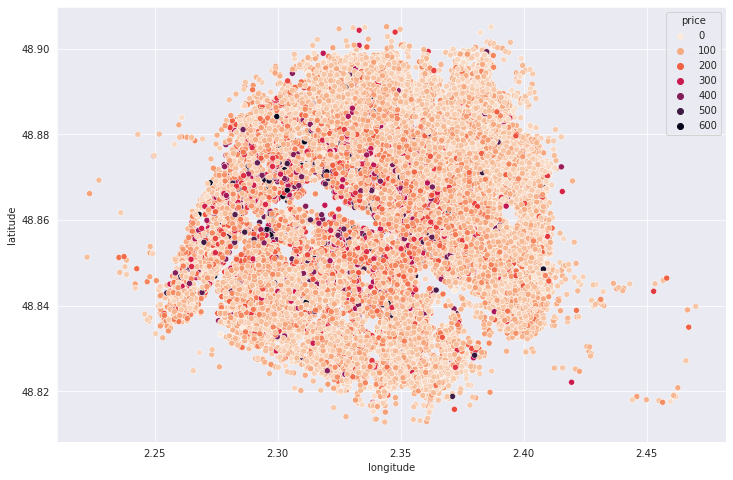

In [ ]:
# Visualização por preço

plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_clean.longitude,df_clean.latitude,hue=df_clean.price,palette='rocket_r')
plt.ioff()

### Tipos de imóveis

In [ ]:
# Quantidade de cada tipo de imóvel disponível

df_clean['room_type'].value_counts() 

Entire home/apt    41148
Private room        7110
Hotel room          1175
Shared room          353
Name: room_type, dtype: int64

In [ ]:
# Porcentagem de cada tipo de imóvel disponível

df_clean['room_type'].value_counts() / len(df_clean)

Entire home/apt    0.826497
Private room       0.142811
Hotel room         0.023601
Shared room        0.007090
Name: room_type, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


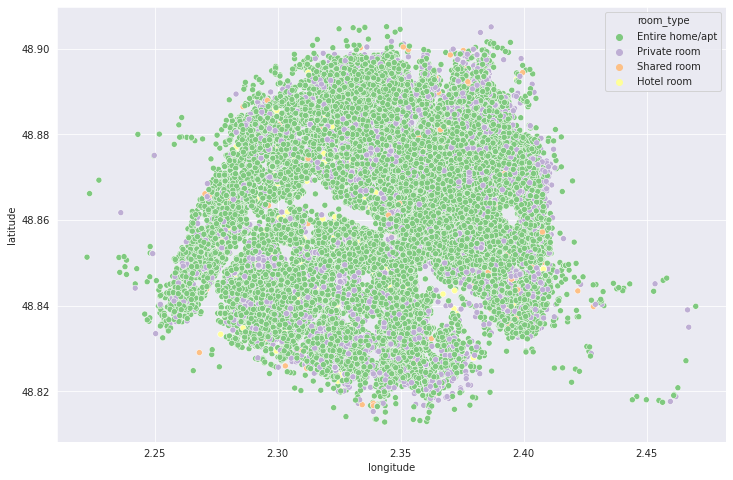

In [ ]:
# Visualização por tipo de acomodação
plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_clean.longitude,df_clean.latitude,hue=df_clean.room_type)
plt.ioff()

### Tamanho dos imóveis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


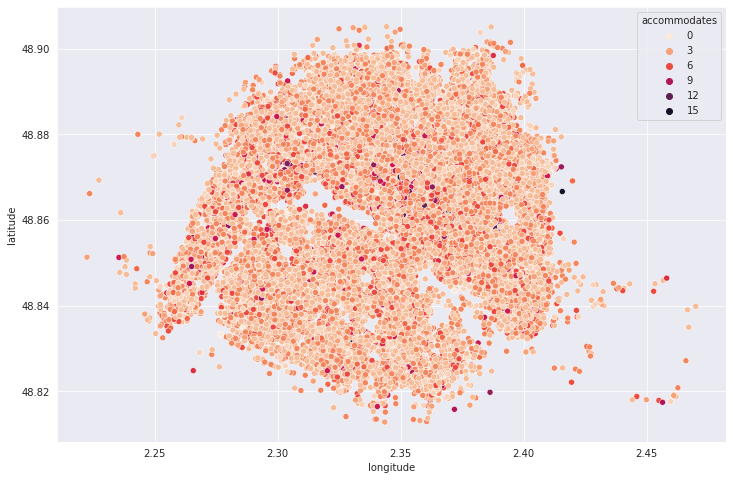

In [ ]:
# Visualização por número de hóspedes

plot_dims=(12,8)
plt.figure(figsize=plot_dims)
sns.scatterplot(df_clean.longitude,df_clean.latitude,hue=df_clean.accommodates,palette='rocket_r')
plt.ioff()

# Construção dos modelos de Machine Learning
Neste momento, são realizados testes de diferentes modelos de Machine Learning para encontrar aquele que tem melhores resultados.

In [ ]:
# Transformação de variáveis categóricas

df_clean_dummies = pd.get_dummies(data=df_clean, drop_first=True)
df_clean_dummies.head()

,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,distance_to_TourEiffel,distance_to_Louvre,distance_to_NotreDame,distance_to_Arc,distance_to_SacreCoeur,distance_to_Pantheon,distance_to_Place,host_is_superhost_t,host_has_profile_pic_t,neighbourhood_cleansed_Bourse,neighbourhood_cleansed_Buttes-Chaumont,neighbourhood_cleansed_Buttes-Montmartre,neighbourhood_cleansed_Entrepôt,neighbourhood_cleansed_Gobelins,neighbourhood_cleansed_Hôtel-de-Ville,neighbourhood_cleansed_Louvre,neighbourhood_cleansed_Luxembourg,neighbourhood_cleansed_Ménilmontant,neighbourhood_cleansed_Observatoire,neighbourhood_cleansed_Opéra,neighbourhood_cleansed_Palais-Bourbon,neighbourhood_cleansed_Panthéon,neighbourhood_cleansed_Passy,neighbourhood_cleansed_Popincourt,neighbourhood_cleansed_Reuilly,neighbourhood_cleansed_Temple,neighbourhood_cleansed_Vaugirard,neighbourhood_cleansed_Élysée,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t
0,48.86957,2.36127,4,125.0,3,1125,364,1,5.000000,5.043472,2.087812,2.024797,4.868185,2.219958,2.829708,1.582061,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,48.87417,2.34245,2,130.0,6,365,352,6,4.800000,3.926961,1.540517,2.427091,3.468829,1.274748,3.124924,2.666514,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,48.86006,2.34863,2,75.0,180,365,358,0,4.586515,3.965582,0.939451,0.799848,4.207720,2.870241,1.555502,1.332685,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,48.86373,2.37093,2,80.0,4,31,144,28,4.930000,5.624944,2.582955,1.943682,5.664077,3.167694,2.668582,0.983459,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,48.88700,2.34531,2,80.0,30,300,279,48,4.840000,4.899314,2.971817,3.805435,3.960418,0.216193,4.541079,3.790667,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Divisão do dataset em treinamento e teste

X = df_clean_dummies.drop(['price', 'latitude', 'longitude'], axis=1)
Y = df_clean_dummies['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34850, 38)
(14936, 38)
(34850,)
(14936,)


In [ ]:
# Normalização dos dados com MaxAbsScaler

norm = MaxAbsScaler()
norm = norm.fit(X_train)

X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

### Linear Regression

In [ ]:
# Linear Regression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [ ]:
# Parâmetros

r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae = metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
lr_scores = pd.DataFrame({'Linear Regression' : [r2,rmse, mae]}, index=['R2', 'RMSE', 'MAE'])
lr_scores

,Linear Regression
R2,0.450104
RMSE,62.806302
MAE,39.653112


### Random Forest

In [ ]:
# Random Forest Regression

rf_model = RandomForestRegressor(
           min_samples_leaf=1,
           n_estimators= 1000,
           n_jobs=6,
           random_state=0)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
# Parâmetros

r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae = metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
rf_scores = pd.DataFrame({'Random Forest' : [r2, rmse, mae]}, index=['R2', 'RMSE', 'MAE'])
rf_scores

,Random Forest
R2,0.530005
RMSE,58.064353
MAE,35.765929


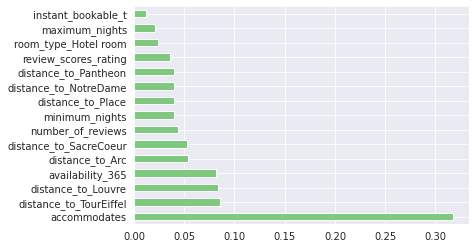

In [ ]:
# Importância das variáveis

feat_importances = pd.Series(rf_model.feature_importances_, index= X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

### XGBoost

In [ ]:
# XGBoost Regression

xgb_model = xgb.XGBRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=0.001,
    n_estimators=1000)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

[18:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Parâmetros

r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae = metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
xgb_scores = pd.DataFrame({'XGBoost' : [r2, rmse, mae]}, index=['R2', 'RMSE', 'MAE'])
xgb_scores

,XGBoost
R2,0.534006
RMSE,57.816659
MAE,35.270213


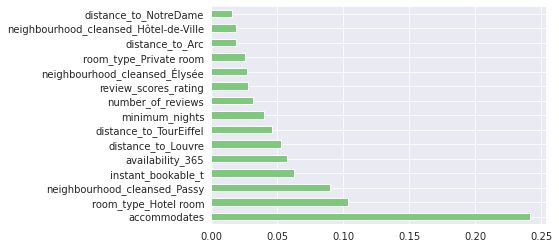

In [ ]:
# Importância das Variáveis

feat_importances = pd.Series(xgb_model.feature_importances_, index= X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [ ]:
scores = pd.concat([lr_scores, rf_scores, xgb_scores], axis=1)
index = ['R2','RMSE','MAE']
scores.index = index
scores

,Linear Regression,Random Forest,XGBoost
R2,0.450104,0.530005,0.534006
RMSE,62.806302,58.064353,57.816659
MAE,39.653112,35.765929,35.270213
